<a href="https://colab.research.google.com/github/Jaramilloh/Angular-Super-Resolution-Based-on-Residual-Network/blob/main/AngularSRResNet_v9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Angular Super Resolution Based on Residual Network (TesorFlow-Python).


This notebook will show you step for step, the procedures in need to implement a deep network for augment angular resolution on light fields.

Each sample will be represented as the angular matrix in a fixed spatial point. Since we're working with light fields captured with Lytro First Generation Camera, each ground truth sample will be a matrix of 10x10 pixels, and the downsampled ones will be a matrix of 5x5 pixels. Therefore, the model will be trained to augment an angular matrix of 5x5 pixels to an angular matrix of 10x10 pixels. Moreover, each sample will be treat as an image of 3 channels.


In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         148G   40G  109G  27% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
/dev/sda1       154G   41G  113G  27% /opt/bin
tmpfs           6.4G  372K  6.4G   1% /var/colab
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G   11G  4.7G  69% /content/drive


In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0x1
cpu MHz		: 2000.174
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	:

In [ ]:
!cat /proc/meminfo

MemTotal:       13333564 kB
MemFree:        10624508 kB
MemAvailable:   12472112 kB
Buffers:          103480 kB
Cached:          1891380 kB
SwapCached:            0 kB
Active:           987692 kB
Inactive:        1409372 kB
Active(anon):     374800 kB
Inactive(anon):      404 kB
Active(file):     612892 kB
Inactive(file):  1408968 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              4132 kB
Writeback:             0 kB
AnonPages:        402208 kB
Mapped:           216172 kB
Shmem:              1008 kB
Slab:             178780 kB
SReclaimable:     133036 kB
SUnreclaim:        45744 kB
KernelStack:        4208 kB
PageTables:         5500 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6666780 kB
Committed_AS:    2998984 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:             1048 kB
AnonHugePages:   

In [ ]:
!nvidia-smi

Mon May 10 02:05:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import used libraries

In [ ]:
import datetime
import time
import sys
import os 
import random
import glob

import h5py
import cv2
import numpy as np
import tensorflow as tf
import functools

import matplotlib
from matplotlib import pyplot as plt
from IPython import display

import pandas as pd
import csv

  Donwload dataset file

In [ ]:
# Donwload dataset
import gdown
url="https://drive.google.com/uc?id=1FkXZCNqhB57jSXJXwZC0nuWHVbpDKGPY"
fileName="angular_dataset.h5"
gdown.download(url, fileName, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1FkXZCNqhB57jSXJXwZC0nuWHVbpDKGPY
To: /content/angular_dataset.h5
310MB [00:02, 111MB/s]


'angular_dataset.h5'

Load dataset file

In [ ]:
with h5py.File(fileName, 'r') as hf:
  '''
  Load the dataset in memory since it have a light weight
  '''
  train_len = len(hf['X_ang_train'][:])
  test_len = len(hf['Y_ang_test'][:])
  hlr,wlr,c = hf['X_ang_train'][0].shape
  hhr,whr,c = hf['Y_ang_train'][0].shape

  # normalization between [-1, 1]
  train_lr_img = np.float32(hf['X_ang_train'][:]) / 127.5 - 1
  train_hr_img = np.float32(hf['Y_ang_train'][:]) / 127.5 - 1

  test_lr_img = np.float32(hf['X_ang_test'][:]) / 127.5 - 1
  test_hr_img = np.float32(hf['Y_ang_test'][:]) / 127.5 - 1


def load(LRimage, HRimage):
  '''
  Cast the images specified as tf.float32
    Inputs: LR, HR images files
    Outputs: LR, HR images loaded as tensor
  '''
  LRimage = tf.cast(LRimage, tf.float32)
  HRimage = tf.cast(HRimage, tf.float32)
  return LRimage, HRimage

print("Initializing Train dataset...")
BATCH_SIZE = 256
SHUFFLE = len(train_lr_img)
############################## TRAIN DATASET ###################################
train_dataset = tf.data.Dataset.from_tensor_slices((train_lr_img, train_hr_img))
train_dataset = train_dataset.map(load, num_parallel_calls=tf.data.AUTOTUNE).cache().batch(BATCH_SIZE) # Assign number of batches
train_dataset = train_dataset.shuffle(SHUFFLE).prefetch(tf.data.AUTOTUNE)
print("done")

print("\nInittializing Test dataset...")
############################ VALDATION DATASET #################################
test_dataset = tf.data.Dataset.from_tensor_slices((test_lr_img, test_hr_img))
test_dataset = test_dataset.map(load, num_parallel_calls=tf.data.AUTOTUNE).cache().batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)
print("done")

Initializing Train dataset...
done

Inittializing Test dataset...
done


Load some validation LF to visual appreciation the training

In [ ]:
# Save 6 different validation images for visual purposes
lr = []
hr = []

cont = 0
x = [18, 98, 113, 181, 236, 251]
imgshrVAL = []
imgslrVAL = []
for input_img, target_img in test_dataset.take(2):
  print(input_img.shape)
  lr = input_img
  hr = target_img

for i in range(256):
  for y in x:
    if y == i: 
      imgslrVAL.append(lr[i])
      imgshrVAL.append(hr[i])
      plt.imshow(hr[i] * 0.5 + 0.5)
      plt.show()
      break          

In [ ]:
for i in range(len(imgshrVAL)):
  plt.imshow(imgslrVAL[i] * 0.5 + 0.5)
  plt.show()

Define the super-resolution model

In [ ]:
def ResDenseBlock_5C(x):
  '''
  Residual Dense Block with 5 convolutions,
  based on: https://github.com/peteryuX/esrgan-tf2/blob/master/modules/models.py
  https://arxiv.org/pdf/1809.00219.pdf ESRGAN
  (similar to https://arxiv.org/pdf/1707.02921.pdf EDSR)
      Inputs:
          x: input layers
      Output:
          result: above layers stacked
  '''
  res_beta = 0.25
  lrelu_f = functools.partial(tf.keras.layers.LeakyReLU, alpha=0.2)
  x1 = tf.keras.layers.Conv2D(64, 3, strides=1, padding='same',kernel_initializer=_kernel_init(0.1),bias_initializer='zeros',kernel_regularizer=_regularizer(0.),activation=lrelu_f())(x)
  x2 = tf.keras.layers.Conv2D(64, 3, strides=1, padding='same',kernel_initializer=_kernel_init(0.1),bias_initializer='zeros',kernel_regularizer=_regularizer(0.),activation=lrelu_f())(tf.keras.layers.Concatenate()([x, x1]))
  x3 = tf.keras.layers.Conv2D(64, 3, strides=1, padding='same',kernel_initializer=_kernel_init(0.1),bias_initializer='zeros',kernel_regularizer=_regularizer(0.),activation=lrelu_f())(tf.keras.layers.Concatenate()([x, x1, x2]))
  x4 = tf.keras.layers.Conv2D(64, 3, strides=1, padding='same',kernel_initializer=_kernel_init(0.1),bias_initializer='zeros',kernel_regularizer=_regularizer(0.),activation=lrelu_f())(tf.keras.layers.Concatenate()([x, x1, x2, x3]))
  x5 = tf.keras.layers.Conv2D(64, 3, strides=1, padding='same',kernel_initializer=_kernel_init(0.1),bias_initializer='zeros',kernel_regularizer=_regularizer(0.),activation=lrelu_f())(tf.keras.layers.Concatenate()([x, x1, x2, x3, x4]))
  x6 = tf.keras.layers.Conv2D(64, 3, strides=1, padding='same',kernel_initializer=_kernel_init(0.1),bias_initializer='zeros',kernel_regularizer=_regularizer(0.),activation=lrelu_f())(tf.keras.layers.Concatenate()([x, x1, x2, x3, x4, x5]))
  x7 = tf.keras.layers.Conv2D(64, 3, strides=1, padding='same',kernel_initializer=_kernel_init(0.1),bias_initializer='zeros',kernel_regularizer=_regularizer(0.),activation=lrelu_f())(tf.keras.layers.Concatenate()([x, x1, x2, x3, x4, x5, x6]))
  x8 = tf.keras.layers.Conv2D(64, 3, strides=1, padding='same',kernel_initializer=_kernel_init(0.1),bias_initializer='zeros',kernel_regularizer=_regularizer(0.),activation=lrelu_f())(tf.keras.layers.Concatenate()([x, x1, x2, x3, x4, x5, x6, x7]))

  return tf.keras.layers.Add()([x8 * res_beta, x])
  
def ResInResDenseBlock(x):
  '''
  Function for connect multiple Residual Dense Blocks
  based on: https://github.com/peteryuX/esrgan-tf2/blob/master/modules/models.py
  https://arxiv.org/pdf/1707.02921.pdf ESRGAN
      Inputs:
          x: input layers
      Output:
          result: above layers stacked
  '''
  res_beta = 0.35
  x1 = ResDenseBlock_5C(x)
  x2 = ResDenseBlock_5C(x1)
  x3 = ResDenseBlock_5C(x2)
  x4 = ResDenseBlock_5C(x3)
  x5 = ResDenseBlock_5C(x4)
  x6 = ResDenseBlock_5C(x5)
  x7 = ResDenseBlock_5C(x6)
  x8 = ResDenseBlock_5C(x7)
  return tf.keras.layers.Add()([x8 * res_beta, x])

def _regularizer(weights_decay=2e-4):
  '''
  Function to initialize a L2 norm regualrizator
  '''
  return tf.keras.regularizers.l2(weights_decay)
  
def _kernel_init(scale=1.0, seed=None):
  '''
  Normal distribution weight initializer with scale.
  '''
  scale = 2. * scale
  return tf.keras.initializers.VarianceScaling(scale=scale, mode='fan_in', distribution="truncated_normal", seed=seed)

def Generator():
  '''
  Generator architecture inspired on ResDenseBlock architecture for GANs
  super resolution, based on: https://github.com/peteryuX/esrgan-tf2/blob/master/modules/models.py
  https://arxiv.org/pdf/1809.00219.pdf ESRGAN
      Input: image with (h, w, 3) shape
      Output: super-resolved image with (h*2, w*2, 3) shape
  '''
  inputx = tf.keras.layers.Input(shape=[hlr, wlr, c])

  ######################## extracion of features ###############################
  # First convolution
  x = tf.keras.layers.Conv2D(64, 3, strides=1, padding='same', kernel_initializer=_kernel_init(), bias_initializer='zeros', kernel_regularizer=_regularizer(0.))(inputx)
  # Residual In Residual dense blocks
  x1 = ResInResDenseBlock(x)
  # Second convolution afer ResInRes dense blocks
  x3 = tf.keras.layers.Conv2D(64, 3, strides=1, padding='same',kernel_initializer=_kernel_init(),bias_initializer='zeros',kernel_regularizer=_regularizer(0.))(x1)
  x = tf.keras.layers.Add()([x3, x])

  ######################### Upsampling layers ##################################
  # Pixel-shuffle convolution; (5, 5, 3) -> (10, 10, 3)
  x = tf.keras.layers.Conv2D(64, 3, strides=1, padding='same',kernel_initializer=_kernel_init(),bias_initializer='zeros',kernel_regularizer=_regularizer(0.))(x)
  x = tf.nn.depth_to_space(x, 2)

  # Concatenation with the LR input upsampled by bilinear interpolation, thus keeping original color in the final result
  x1 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(inputx)
  x2 = tf.keras.layers.Concatenate()([x, x1])

  # Convolutional layers to learn some len's characteristics
  x1 = tf.keras.layers.Conv2D(64, 3, strides=1, padding='same',kernel_initializer=_kernel_init(),bias_initializer='zeros',kernel_regularizer=_regularizer(0.))(x2)
  # Residual In Residual dense blocks
  x = ResInResDenseBlock(x1)
  x3 = ResInResDenseBlock(x)
  x4 = tf.keras.layers.Conv2D(64, 3, strides=1, padding='same',kernel_initializer=_kernel_init(),bias_initializer='zeros',kernel_regularizer=_regularizer(0.))(x3)
  x = tf.keras.layers.Add()([x1, x4])
  
  x = tf.keras.layers.Conv2D(c, 3, strides=1, padding='same',kernel_initializer=_kernel_init(),bias_initializer='zeros',kernel_regularizer=_regularizer(0.),activation='tanh')(x) #pixel values in [-1, 1]
  
  return tf.keras.Model(inputs=inputx, outputs=x)

Define the training loss

$L1_{I_{HR}, I_{SR}} = \frac{1}{N}\sum_{i=0}^{N}\left \|I_{HR_{i}} - I_{SR_{i}} \right \|$


In [ ]:
mae_object = tf.keras.losses.MeanSquaredError()
def PixelLoss(target, gen_output):
  '''
  Function to calculate pixel loss between images
      Inputs:
          gen_output: generated image
          target: target image
      Output:
          Content Loss; L2 norm between images
  '''
  # Calculate L2 loss between piexls
  loss_func = mae_object(target, gen_output)
  return loss_func

Define the register file to save the training checkpoints, that is, the weights and training variables of the network.


In [ ]:
!rm -rf drive/MyDrive/Mi_Modelo/Training_checkpoints/SRResNet_v9

In [ ]:
checkpoint_dir = 'drive/MyDrive/Mi_Modelo/Training_checkpoints/SRResNet_v9'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

generator=Generator()
generator_optimizer = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.9)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,generator=generator)

Define a function to calculate the loss in each batch of the training dataset. Each time the loss is calulated, it is applied the backpropagation into the neural network, thus updating each neuron with the calculated gradient.

In [ ]:
def train_step(input_image, target):
  '''
  Function for each step in the training proccess of Generative network;
  it calculates the loss at each sample batc in train dataset,
  and then applies backpropagation to generate the gradients for trainable
  variables on the network, thus applying the gradients to the optimizers.
      Inputs:
          input_image: LR image batch
          target: HR image bacth
          epoch: actual epoch
  '''
  with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
    # add noise to input image
    input_image = tf.keras.layers.GaussianNoise(0.01)(input_image)
    gen_output = generator(input_image,  training=True) # Generate output from lr input
    # Calculate Pixel Loss
    pix_loss = PixelLoss(target, gen_output)
    total_loss = 100*pix_loss + tf.reduce_sum(generator.losses)
  # Generate gradient for trainable weights in generator, feature extractor
  grad_gen = g_tape.gradient(total_loss, generator.trainable_variables)
  # Optimize network by applying the gradient in generator, feature extractor
  generator_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))
  return 100*pix_loss

Define a function to plot the selected angular matrices from the validation dataset, in order to plot it at the beginning of each epoch until the training is end.

In [ ]:
!mkdir -m 777 drive/MyDrive/Mi_Modelo/Test/SRResNet_v9

In [ ]:
def generate_images(prediction, test_input, tar, img, epoch):
  '''
  Function to generate images by the generator network and plot the result, next
  to the ground truth and the input image.
      Inputs:
          prediction: SR image
          test_input: LR image
          tar: HR image
  '''
  plt.figure(figsize=(16.2, 16.2))
  display_list = [test_input, tar, prediction]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  name = 'drive/MyDrive/Mi_Modelo/Test/SRResNet_v9/img' + str(img) + '_validacion_epoch_'+ str(epoch) + '.png'
  plt.savefig(name)
  plt.show()
  plt.close()

Define the register file to save the training results which will be plotted at the end of the training process

In [ ]:
!rm -rf drive/MyDrive/Mi_Modelo/Logs/SRResNet_v9

In [ ]:
# define a logs writer
log_dir="drive/MyDrive/Mi_Modelo/Logs/SRResNet_v9/"
summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
EPOCHS = 12

Training loop function

In [ ]:
print("\nInitialize learning in the SRResNet... ")
start_time = time.time()
cont = 0
for epoch in range(EPOCHS):
  
  # PRINT VALIDATION VALUES
  for i in range(len(imgshrVAL)):
    imglr = tf.expand_dims(imgslrVAL[i], axis=0)
    gen_output = generator(imglr,  training=False) # Generate output from lr input
    generate_images(gen_output[0], imglr[0], imgshrVAL[i], i, epoch)

  # TRAIN LOOP
  px_loss = 0.0
  num_batches = 0
  for n, (input_img, target_img) in train_dataset.enumerate():

    if (cont+1)%1000 == 0:
      display.clear_output()

    pixel_loss = train_step(input_img, target_img)
    px_loss += pixel_loss
    print("EPOCH %d step %d: L2 loss %f" % (epoch,n,pixel_loss))
    num_batches += 1
    cont += 1

  pixel_loss = px_loss / num_batches

  # TEST LOOP
  test_loss = []
  for n, (input_img, target_img) in test_dataset.enumerate():
    gen_output = generator(input_img,  training=False) # Generate output from lr input
    # Calculate Pixel Loss
    pix_loss = PixelLoss(target_img, gen_output)
    test_loss.append(pix_loss)
    L2_loss = np.mean(test_loss)
    print("EPOCH %d: Training L2 loss %f, L2 test loss %f" % (epoch,pixel_loss,L2_loss))  
  
  if epoch % 2 == 0:
    checkpoint.save(checkpoint_prefix)

  with summary_writer.as_default():
    tf.summary.scalar('l2_train_loss', pixel_loss, step=epoch)

  with summary_writer.as_default():
    tf.summary.scalar('l2_test_loss', L2_loss, step=epoch)

print("--- Elapsed time for training: %s seconds ---" % (time.time() - start_time))
print("Saving model...")
!rm -rf drive/MyDrive/Mi_Modelo/Model/generator_v9
generator.save('drive/MyDrive/Mi_Modelo/Model/generator_v9')
print("Model saved succesfully.. Exit program")

tf.keras.utils.plot_model(generator, 'drive/MyDrive/Mi_Modelo/Model/generator_model_v9.png', show_shapes=True, dpi=64)

Plot the training loss in the training and validation datasets within each epoch.

In [ ]:
import tensorflow as tf

'''
Load tensorboard, a new framework to follow closely the logs saved in the
training progress, the window should be reloaded each time to see actual progress
in the logged losses of each network.
'''
log_dir="drive/MyDrive/Mi_Modelo/Logs/SRResNet_v9/"
%load_ext tensorboard
%tensorboard --logdir {log_dir}

In [ ]:
%reload_ext tensorboard

##Valdation Protocol

Load a training checkpoint

In [ ]:
#checkpoint_dir = 'drive/MyDrive/Mi_Modelo/Training_checkpoints/SRResNet_v9'
!ls {checkpoint_dir}

In [ ]:
#checkpoint_dir = 'drive/MyDrive/Mi_Modelo/Training_checkpoints/SRResNet_v9'
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Load the inference trained model

In [ ]:
generator = tf.keras.models.load_model('drive/MyDrive/Mi_Modelo/Model/generator_v9')

Functions to process the sub-aperture images

In [ ]:
def AngularExtraction(imgs, st_lr):
  '''
  Function to extract the angular matrices for each spatial point tha compounds
  the light field.
    Input:
      img: sub-apertura images of LF
      st_lr: angular donwsampled resolution
  '''
  ang_mtx = []
  height = imgs[0].shape[0]
  width = imgs[0].shape[1]
  for u in range(height):
    print('.', end="")
    for v in range(width):
      a_mtx = np.zeros((st_lr, st_lr, 3), np.uint8)
      i = 0
      for s in range(st_lr):
        for t in range(st_lr):
          img = imgs[i]
          a_mtx[s, t, :] = img[u, v, :]
          i += 1
      a_mtx = (np.float32(a_mtx) / 127.5) - 1 # Normalization between [-1, 1]
 
      ang_mtx.append(a_mtx)

  return ang_mtx

def load(LRimage):
  '''
  Cast the images specified as tf.float32
    Inputs: LR, HR images files
  '''
  LRimage = tf.cast(LRimage, tf.float32)
  return LRimage

def SynthesizeImgs(a_mtxdwn, st_hr, h, w, pth_frames, folder, indx):  
  '''
  Function to synthesize and save the new sub-aperture images from the angular
  upsampled matrices of the corresponding LF
  '''
  imgs_new = []
  for s in range(st_hr):
    for t in range(st_hr):
      img = np.zeros((int(h), int(w), 3), np.uint8)
      i = 0
      for u in range(int(h)):
        for v in range(int(w)):
          img[u, v, :] = a_mtxdwn[i][s, t, :]
          i += 1
      print('.', end="")
      imgs_new.append(img)

  print("Saving angular new %s sub-aperture images into %s..." % (indx,(pth_frames+folder+'_'+indx))) 
  if not os.path.exists(pth_frames+folder+'_'+indx):
    os.makedirs(pth_frames+folder+'_'+indx)
  cont = 1
  i = 0
  filenames = []
  for s in range(st_hr):
    auxx = imgs_new[i:(st_hr+i)]
    if s%2 == 0:
      init = 0
      step = 1
      finish = st_hr
    else:
      init = st_hr-1
      step = -1
      finish = -1
      auxx.reverse()
    j = 0  
    for t in range(init, finish, step):
      name = "%s%s_%s/%s_%03d_%02d_%02d.png" % (pth_frames, folder, indx, folder, cont, s+1, t+1)      
      cv2.imwrite(name, auxx[j])
      cont+=1
      j += 1
      filenames.append(name)
      print('.', end="")
    i += st_hr
  print()
  print("done")
  return filenames

def save_frames(files):
  '''
  Function to save sub-aperture images into list in order to pass to video
  constructor
    Input:
      files: list with complete file name of sub-aperture images
    Outputs:
      frame_array: list with the frames
      height: number of rows in frames
      width: number of columns in frames
  '''
  frame_array = []
  for i in files:
    img = cv2.imread(i)
    height, width = img.shape[0:2]
    frame_array.append(img)
  return frame_array, height, width

def write_video(frame_array, name, height, width):
  '''
  Function to invoke a video codec constructor in order to insert frames and
  generate a video with the sub-aperture images
    Inputs:
      frame_array: list with the frames
      name: name of the video to save
      height: number of rows in frames
      width: number of columns in frames
  '''
  #fourcc = cv2.VideoWriter_fourcc(*'XVID') - Linux
  #fourcc = cv2.VideoWriter_fourcc('M','J','P','G') - Windows, avi
  fourcc = cv2.VideoWriter_fourcc(*'mp4v') # MP4
  out = cv2.VideoWriter(name,fourcc, 23.0, (width,height))
  for i in range(len(frame_array)):
    out.write(frame_array[i]) # writing the frame into the codec constructor
  out.release()

Iterate over all validation light fields, downsampling its angular matrices and super resolving it with the inference model, sinthesizing the new sub-aperture images and a vidio of these with the minium optical flow

In [ ]:
# Path withl LF subimages
pth_frames = 'drive/MyDrive/Mi_Modelo/Validation_LF/'

f_list = os.listdir(pth_frames)
LRfolders = []
HRfolders = []
SRfolders = []
for i in f_list:
  if 'adownsampled' in i: # divide LR and HR folder's names in two list: LRfolders, HRfolders 
    LRfolders.append(i)
  elif ('SRv9') in i:
    SRfolders.append(i)
  elif ('adownsampled' not in i) and ('SRv9' not in i) and ('SRv10' not in i) and ('SRv8' not in i) and ('BC' not in i) and ('NR' not in i) and ('LC' not in i):
    HRfolders.append(i)
  SRfolders.sort()
  LRfolders.sort()
  HRfolders.sort()

if len(HRfolders) != len(LRfolders):
  print("Number of LF are not symetric within different methods of upscaling... Exit program")
  sys.exit("aa! errors!")

# Delete previous experiments
for i in range(len(SRfolders)):
  os.system("rm -rf drive/MyDrive/Mi_Modelo/Validation_LF/{}".format(SRfolders[i]))

st_hr, st_lr = 10, 5 # original angular resolution, downsampled angular resolution

# Iterate over all evaluation light fields
for folder, HRfolder in zip(LRfolders, HRfolders):

  start_time = time.time()

  print("\nProcessing light field %s " % (folder))
  subimgs_list = glob.glob(pth_frames+folder+'/*.png')
  subimgs_list.sort()

  appnd = [f[-7:] for f in subimgs_list] # Auxiliar to obtain angular indices from each sub-aperture image
  appnd.sort()

  subimgs = [] # List to save sub-aperture images with a order corresponding to the angular resolution
  for i in appnd:
    for f in subimgs_list:
      if i in f[-7:]:
        subimg = cv2.imread(f)
        h, w, _ = subimg.shape
        subimgs.append(subimg)
        break  

  print("Angular extraction ...", end="")
  ang_mtx = AngularExtraction(subimgs, st_lr)
  print('')
  print("done")

  '''
  start_timeNR = time.time()
  NR_mtx = []
  for i in range(len(ang_mtx)):
    a_mtx = np.uint8((ang_mtx[i] + 1) * 127.5)
    nr_mtx = cv2.resize(a_mtx, None, fx=2, fy=2, interpolation=cv2.INTER_NEAREST)
    NR_mtx.append(nr_mtx)
  print(len(NR_mtx))
  print("--- Elapsed time for NR interpolation: %s seconds ---" % (time.time() - start_timeNR))

  start_timeBC = time.time()
  BC_mtx = []
  for i in range(len(ang_mtx)):
    a_mtx = np.uint8((ang_mtx[i] + 1) * 127.5)
    bc_mtx = cv2.resize(a_mtx, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    BC_mtx.append(bc_mtx)
  print(len(BC_mtx))
  print("--- Elapsed time for BC interpolation: %s seconds ---" % (time.time() - start_timeBC))

  start_timeLC = time.time()
  LC_mtx = []
  for i in range(len(ang_mtx)):
    a_mtx = np.uint8((ang_mtx[i] + 1) * 127.5)
    lc_mtx = cv2.resize(a_mtx, None, fx=2, fy=2, interpolation=cv2.INTER_LANCZOS4)
    LC_mtx.append(lc_mtx)
  print(len(LC_mtx))
  print("--- Elapsed time for LC interpolation: %s seconds ---" % (time.time() - start_timeLC))
  '''

  #start_timeSR = time.time()
  print("Processing %d angular matrices for LF %s" % (len(ang_mtx), folder))
  BATCH_SIZE = len(ang_mtx)//16
  print("Creating dataset iterator with %d batch size" % (BATCH_SIZE))
  lf_dataset = tf.data.Dataset.from_tensor_slices(ang_mtx)
  lf_dataset = lf_dataset.map(load, num_parallel_calls=tf.data.AUTOTUNE)
  lf_dataset = lf_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  print("done")

  ang_mtx_SR = [] # List to save the SR angular matrices
  print("Applyng angular SR to LF %s" % (folder), end="")
  for n, example_input in lf_dataset.enumerate():
    #start_timeSR2 = time.time()
    gen_output = generator(example_input, training=False)
    #print("--- Elapsed time for 1 batch SR: %s seconds ---" % (time.time() - start_timeSR2))
    print('.', end="")
    for i in range(example_input.shape[0]): # Loop to iterate over the batch samples
      sr_mtx = gen_output[i].numpy()
      sr_mtx = np.uint8((sr_mtx + 1) * 127.5)
      ang_mtx_SR.append(sr_mtx)
  print('')
  print("done")
  #print("--- Elapsed time for SR: %s seconds ---" % (time.time() - start_timeSR))
  
  #start_time_imgs = time.time()
  SRsubimgs_list = SynthesizeImgs(ang_mtx_SR, st_hr, h, w, pth_frames, HRfolder, 'SRv9')
  #print("--- Elapsed time synthesizing new sub-aperture images: %s seconds ---" % (time.time() - start_time_imgs))

  print("Generating video for angular SR light field...")
  frame_array, height, width = save_frames(SRsubimgs_list)
  VD_pth = '/content/drive/MyDrive/Mi_Modelo/Videos/'
  name = VD_pth + HRfolder + '_SRv9_video.mp4'
  write_video(frame_array, name, height, width)
  print("Video %s has been saved correctly..." % (name))
  
  print("--- Elapsed time for light field processing: %s seconds ---" % (time.time() - start_time))



Processing light field IMG_0003_adownsampled 
Angular extraction ...................................................................................................................................................................................................................................................................
done
Processing 65536 angular matrices for LF IMG_0003_adownsampled
Creating dataset iterator with 4096 batch size
done
Applyng angular SR to LF IMG_0003_adownsampledWARNING:tensorflow:5 out of the last 5 calls to <function recreate_function.<locals>.restored_function_body at 0x7f843f1de3b0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relax

Measure the proposed system

The equation of the Power signal/noise ratio (PSNR) between the maxium possible pixel value and the mean squared error between each HR sub-aperture image and the SR sub-aperture image is given by:

$PSNR_{I_{HR}, I_{SR}} = 20*ln\left ( \frac{1.0}{\sqrt{\frac{1}{N}\sum (I_{HR}-I_{SR})^{2}}} \right )$

PSNR calculated over angular super-resolved lightfields, and angular interpolated lightfields with the traditional interpolation techniques.



Evaluation of light field IMG_0003 
SR: PSNR 34.957060 dB 
Nearest: PSNR 33.090151 dB 
Bicubic: PSNR 38.454280 dB 
Lanczos: PSNR 38.681637 dB 
--- Elapsed time: 182.8839395046234 seconds ---

Evaluation of light field IMG_0004 
SR: PSNR 37.979153 dB 
Nearest: PSNR 32.977042 dB 
Bicubic: PSNR 36.916685 dB 
Lanczos: PSNR 37.167899 dB 
--- Elapsed time: 186.11034750938416 seconds ---

Evaluation of light field IMG_0021 
SR: PSNR 35.789055 dB 
Nearest: PSNR 29.768352 dB 
Bicubic: PSNR 34.299533 dB 
Lanczos: PSNR 34.527570 dB 
--- Elapsed time: 188.08442950248718 seconds ---

Evaluation of light field IMG_0033 
SR: PSNR 36.357206 dB 
Nearest: PSNR 32.839797 dB 
Bicubic: PSNR 36.527916 dB 
Lanczos: PSNR 36.782314 dB 
--- Elapsed time: 175.5448317527771 seconds ---

Evaluation of light field IMG_0042 
SR: PSNR 35.905166 dB 
Nearest: PSNR 30.596797 dB 
Bicubic: PSNR 34.803445 dB 
Lanczos: PSNR 35.125070 dB 
--- Elapsed time: 186.82694673538208 seconds ---

Evaluation of light field IMG_0061 


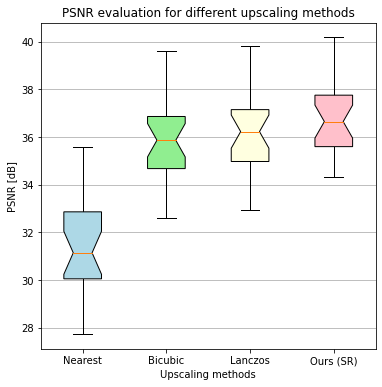

In [ ]:
def PSNR(target, gen_output):
  '''
  PSNR calculation between images

  Input:
    target: Original image
    gen_output: Synthesized imagee
  '''
  # getting the pixel values between [0, 1]
  img1 = target / 255.0
  img2 = gen_output / 255.0

  img1 = np.float64(img1)
  img2 = np.float64(img2)
  mse = np.mean((img1 - img2)**2)
  if mse == 0:
    return float('inf')
  return 20 * np.log10(1.0 / np.sqrt(mse))

# Path withl LF subimages
pth_frames = 'drive/MyDrive/Mi_Modelo/Validation_LF/'

f_list = os.listdir(pth_frames)
SRfolders = []
NRfolders = []
BCfolders = []
LCfolders = []
HRfolders = []
for i in f_list:
  if 'SRv9' in i:
    SRfolders.append(i)
  elif 'NR' in i:
    NRfolders.append(i)
  elif 'BC' in i:
    BCfolders.append(i)
  elif 'LC' in i:
    LCfolders.append(i)          
  elif ('adownsampled' not in i) and ('SRv9' not in i) and ('SRv8' not in i) and ('BC' not in i) and ('NR' not in i) and ('LC' not in i):
    HRfolders.append(i)
  SRfolders.sort()
  NRfolders.sort()
  BCfolders.sort()    
  LCfolders.sort()
  HRfolders.sort()

if len(HRfolders)!=len(SRfolders) and len(HRfolders)!=len(BCfolders) and len(HRfolders)!=len(NRfolders) and len(HRfolders)!=len(LCfolders):
  print("Number of LF are not symetric within different methods of upscaling... Exit program")
  sys.exit("aa! errors!")

# Path withl LF subimages
pth_frames = 'drive/MyDrive/Mi_Modelo/Validation_LF/'
def handleimgs(lf_folder):
  imgsfiles = glob.glob(pth_frames+lf_folder+'/*.png')
  imgsfiles.sort()
  return imgsfiles

# Global PSNR for validation dataset (mean value of PSNR for each LF)
srPSNRg = []
nrPSNRg = []
bcPSNRg = []
lcPSNRg = []

startglob_time = time.time()
for SRfolder, NRfolder, BCfolder, LCfolder, HRfolder in zip(SRfolders, NRfolders, BCfolders, LCfolders, HRfolders):

  start_time = time.time()

  print("\nEvaluation of light field %s " % (HRfolder))
  HRsubimgs_list = handleimgs(HRfolder)
  SRsubimgs_list = handleimgs(SRfolder)
  NRsubimgs_list = handleimgs(NRfolder)
  BCsubimgs_list = handleimgs(BCfolder)
  LCsubimgs_list = handleimgs(LCfolder)

  # if the number of folders differs, something is wrong and the program will exit
  if len(HRsubimgs_list)!=len(SRsubimgs_list) and len(HRsubimgs_list)!=len(NRsubimgs_list) and len(HRsubimgs_list)!=len(BCsubimgs_list) and len(HRsubimgs_list)!=len(LCsubimgs_list):
    print("Sub-aperture images are not symetric within different methods of upscaling... Exit program")
    sys.exit("aa! errors!")

  # Local PSNR for each LF of validation dataset (mean value of PSNR for each sub-image)
  srPSNRt = []
  nrPSNRt = []
  bcPSNRt = []
  lcPSNRt = []
  for i in range(len(SRsubimgs_list)):

    target = cv2.imread(HRsubimgs_list[i]) # La imagen sin original sin ruido

    gen_output = cv2.imread(SRsubimgs_list[i]) # La imagen con ruido (re-escalada) con super-resolucion
    psnr = PSNR(target, gen_output)
    srPSNRt.append(psnr)

    gen_output = cv2.imread(NRsubimgs_list[i]) # La imagen con ruido (re-escalada) por nearest-neighboor
    psnr = PSNR(target, gen_output)
    nrPSNRt.append(psnr)

    gen_output = cv2.imread(BCsubimgs_list[i]) # La imagen con ruido (re-escalada) por interpolacion bicubica
    psnr = PSNR(target, gen_output)
    bcPSNRt.append(psnr)

    gen_output = cv2.imread(LCsubimgs_list[i]) # La imagen con ruido (re-escalada) por interpolacion lanczos
    psnr = PSNR(target, gen_output)
    lcPSNRt.append(psnr)

  print("SR: PSNR %f dB " % (np.mean(srPSNRt)))
  print("Nearest: PSNR %f dB " % (np.mean(nrPSNRt)))
  print("Bicubic: PSNR %f dB " % (np.mean(bcPSNRt)))  
  print("Lanczos: PSNR %f dB " % (np.mean(lcPSNRt)))
  print("--- Elapsed time: %s seconds ---" % (time.time() - start_time))

  # Save local PSNR for each up-scaled LF 
  srPSNRt_mean = np.mean(srPSNRt)
  srPSNRg.append(srPSNRt_mean)
  nrPSNRt_mean = np.mean(nrPSNRt)
  nrPSNRg.append(nrPSNRt_mean)
  bcPSNRt_mean = np.mean(bcPSNRt)
  bcPSNRg.append(bcPSNRt_mean)
  lcPSNRt_mean = np.mean(lcPSNRt)
  lcPSNRg.append(lcPSNRt_mean)
  #writer.writerow({'Ours': srPSNRt_mean, 'Nearest': nrPSNRt_mean, 'Bicubic': bcPSNRt_mean, 'Lanczos': lcPSNRt_mean})
  
# Save global PSNR for validation dataset
srPSNRg_mean = np.mean(srPSNRg)
nrPSNRg_mean = np.mean(nrPSNRg)
bcPSNRg_mean = np.mean(bcPSNRg)
lcPSNRg_mean = np.mean(lcPSNRg)

print("\nEvaluation of all Validation Dataset:")
print("SR: PSNR %f dB " % (srPSNRg_mean))
print("Nearest: PSNR %f dB " % (nrPSNRg_mean))
print("Bicubic: PSNR %f dB " % (bcPSNRg_mean))  
print("Lanczos: PSNR %f dB " % (lcPSNRg_mean))
print("--- Elapsed time: %s seconds ---" % (time.time() - startglob_time))

!rm -rf PSNR_results.csv
with open('PSNR_results.csv', 'w', newline='') as file:
  fieldnames = ['Nearest', 'Bicubic', 'Lanczos', 'Ours']
  writer = csv.DictWriter(file, fieldnames=fieldnames)
  writer.writeheader()

  for i in range(len(srPSNRg)):
    writer.writerow({'Nearest': nrPSNRg[i], 'Bicubic': bcPSNRg[i], 'Lanczos': lcPSNRg[i], 'Ours': srPSNRg[i]})

!rm -rf drive/MyDrive/Mi_Modelo/PSNR_results_v9.csv
!cp PSNR_results.csv drive/MyDrive/Mi_Modelo/PSNR_results_v9.csv

# Boxplot
df = pd.read_csv("drive/MyDrive/Mi_Modelo/PSNR_results_v9.csv",delimiter=",")
#print(df.head())

PSNR = df.values
labels = ['Nearest', 'Bicubic', 'Lanczos', 'Ours (SR)']

fig, ax1 = plt.subplots(figsize=(6, 6))

# rectangular box plot
bplot1 = ax1.boxplot(PSNR,
                     notch=True,  # notch shape
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax1.set_title('PSNR evaluation for different upscaling methods')

# fill with colors
colors = ['lightblue', 'lightgreen', 'lightyellow', 'pink']
for patch, color in zip(bplot1['boxes'], colors):
  patch.set_facecolor(color)

# adding horizontal grid lines
ax1.yaxis.grid(True)
ax1.set_xlabel('Upscaling methods')
ax1.set_ylabel('PSNR [dB]')
plt.show()